In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import csv
import json
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import shutil
import time as time

In [2]:
## paths
train1_txt_path = '../data/train/files/train1.txt'
train1_csv_path = '../data/train/files/train1.csv'
train1_img_path = '../data/train/imgs/'
train1_mp4_path = '../data/train/videos/train1.mp4'
model_save_path = '../data/models/sprs15-opflw.pkl'

test_img_path = '../data/test/imgs/'
test_csv_path = '../data/test/files/driving.csv'



In [3]:
## hyper-parameters
num_trn_epochs = 15
num_batch_size = 32
learning_rate = 0.0001


In [4]:
with open(train1_txt_path) as train_speed_file:
    speed_ground=train_speed_file.readlines()
print(len(speed_ground))

20400


In [5]:
train_df = pd.read_csv(train1_csv_path)
train_df.head(5)
#len(train_df)

,image_path,frame,speed
0,../data/train/imgs/0.jpg,0,28.105569
1,../data/train/imgs/1.jpg,1,28.105569
2,../data/train/imgs/2.jpg,2,28.106527
3,../data/train/imgs/3.jpg,3,28.130404
4,../data/train/imgs/4.jpg,4,28.109243


In [6]:
## test data
test_df = pd.read_csv(test_csv_path)
test_df.head(5)

,image_path,frame,speed
0,../data/test/imgs/0.jpg,0,2.022715
1,../data/test/imgs/1.jpg,1,2.040872
2,../data/test/imgs/2.jpg,2,2.062394
3,../data/test/imgs/3.jpg,3,2.076283
4,../data/test/imgs/4.jpg,4,2.077074


In [7]:
# load sub-set of images for code debug purposes  ****** DEBUG ONLY ******** COMMENT
#train_df=train_df.head(322) #161


In [8]:
# VIDEO TO (IMAGES AND CSV FILE)
# only if images have not been extracted then this code block gets executed to generate jpgs from mp4
# make sure that 'train1_img_path' has no jpgs if running for first time 

def write_image_to_disk(idx, cap, writer, item):
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
    
    #read in the image
    success, image = cap.read()
    print success

    if success:
        image_path = os.path.join(train1_img_path, str(idx) + '.jpg')

        #save image to IMG folder
        cv2.imwrite(image_path, image)

        #write row to train1.csv
        writer.writerow({'image_path': image_path,
                  'frame': idx,
                  'speed':float(item),
                 })
        





In [9]:
last_count = 0
if not any(fname.endswith('.jpg') for fname in os.listdir(train1_img_path)):

    with open(train1_csv_path, 'w') as csvfile:
         fieldnames = ['image_path', 'frame', 'speed']
         writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
         writer.writeheader()

         #Path to raw image folder
         abs_path_to_IMG = os.path.join(train1_img_path)

         cap = cv2.VideoCapture(train1_mp4_path)
         cap.set(cv2.CAP_PROP_FRAME_COUNT, len(speed_ground))

         for idx, item in enumerate(speed_ground):
            
            if idx % 100 == 0:
                print idx , 'images extracted .... '
            
            write_image_to_disk(idx, cap, writer, item)
        
         last_count = idx
         
                
            
print('images extracted..')

images extracted..


In [10]:
## take care of regenerating the last image 1 more time to fix the pairs of image count

if last_count != 0 and idx%2 != 0 :
    idx +=1
    print idx
    shutil.copyfile(train1_img_path+ str(idx-1) + '.jpg', train1_img_path + str(idx) + '.jpg')

In [11]:
def brightness_augmentation(img,brightness_factor):
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     print hsv_image.shape
    hsv_image[:,:,2] = hsv_image[:,:,2]*brightness_factor
    img = np.array(hsv_image, dtype = np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img

In [12]:
from sklearn.model_selection import train_test_split

def batch_shuffle(dframe):
    dframe_for_split=dframe[:-1]
    train_data = []
    validation_data = []
    
    train,validation=train_test_split(dframe_for_split, shuffle=False, test_size=0.2) # shuffle false will ensure the logic below of idx2 = idx + 1  will work
    print("--------------------------------")
    print("train length ", len(train))
    print("validation length ", len(validation))
    print('===================================')
    print("training data ", train)
    print('===================================')
    print("validation data ", validation)
    
    print('----------  TRAINING PAIRS --------------------')
    for _,row in train.iterrows():
        idx1=row['frame']
        idx2=idx1+1
        #print('idx1 =%s idx2=%s'%(idx1,idx2))
        
        train_data.append((idx1,idx2))
        
    print('----------  VALIDATION PAIRS --------------------')
    for _,row in validation.iterrows():
        idx1=row['frame']
        idx2=idx1+1
        #print('idx1 =%s idx2=%s'%(idx1,idx2))
        
        validation_data.append((idx1,idx2))
    return train_data, validation_data

In [13]:
x,y = batch_shuffle(train_df)
print "train_pairs"
print len(x)
print ""
print "validation_pairs"
print len(y)

--------------------------------
('train length ', 16319)
('validation length ', 4080)
('training data ',                          image_path  frame      speed
0          ../data/train/imgs/0.jpg      0  28.105569
1          ../data/train/imgs/1.jpg      1  28.105569
2          ../data/train/imgs/2.jpg      2  28.106527
3          ../data/train/imgs/3.jpg      3  28.130404
4          ../data/train/imgs/4.jpg      4  28.109243
5          ../data/train/imgs/5.jpg      5  28.088572
6          ../data/train/imgs/6.jpg      6  28.034211
7          ../data/train/imgs/7.jpg      7  28.018491
8          ../data/train/imgs/8.jpg      8  27.986624
9          ../data/train/imgs/9.jpg      9  28.016352
10        ../data/train/imgs/10.jpg     10  27.981986
11        ../data/train/imgs/11.jpg     11  27.978625
12        ../data/train/imgs/12.jpg     12  28.032331
13        ../data/train/imgs/13.jpg     13  27.960219
14        ../data/train/imgs/14.jpg     14  27.937178
15        ../data/train/imgs/1

In [14]:
def preprocessing(image_path, brightness_factor=None):
    img=cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#
    if brightness_factor:
        img = brightness_augmentation(img, brightness_factor)
    img = cv2.resize(img[100:440, :-90], (220, 66), interpolation = cv2.INTER_AREA)
    return img

In [15]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))




def computeOpticalFlow(img1,img2):  #Sparse Optical Flow
    
    gray1=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
    gray2=cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
    frame=img1 #gray1
    p0 = cv2.goodFeaturesToTrack(gray1, mask = None, **feature_params)
    #print('p0 >>> ',p0)
    
    result = np.zeros((frame.shape[0], frame.shape[1],3), np.uint8)
    if p0 is not None:
        p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)
    
        mask = np.zeros_like(gray1)
        color = np.random.randint(0,255,(100,3))
        good_new = p1[st==1]
        good_old = p0[st==1]
        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)

        #print frame.shape
        #print mask.shape
        #img = cv2.add(frame,mask)
        result = cv2.bitwise_and(frame,frame,mask = mask)

        #print result.shape
        #plt.imshow(result)
        #plt.show()
        # Now update the previous frame and previous points
        #old_gray = gray2.copy()
        #p0 = good_new.reshape(-1,1,2)

    return result
    


In [16]:
img1=preprocessing('../data/train/imgs/0.jpg')
img2=preprocessing('../data/train/imgs/1.jpg')

computeOpticalFlow(img1,img2)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [17]:
import copy
def generate_training_data(tuples, data, batch_size=num_batch_size):
    channels=3
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    batch_data = []
    batch_labels = []
    
    for j in range(len(tuples) /batch_size): #*2
        for i in range(0,batch_size): #,2
            idx = np.random.randint(1, len(tuples) - 1)

            brightness_factor=0.2 + np.random.uniform()

            row1=data.iloc[[tuples[idx][0]]] #idx
            row2=data.iloc[[tuples[idx][1]]] #idx
            
            #print(row1['image_path'])
            img1 = preprocessing(row1['image_path'].values[0],brightness_factor)
            img2 = preprocessing(row2['image_path'].values[0],brightness_factor)
            #print row1['image_path']
            #print row2['image_path']
            
            speed1 = row1['speed'].values[0]
            speed2 = row2['speed'].values[0]

            resimg = computeOpticalFlow(img1,img2)
            speed = np.mean([speed1, speed2])
            
            image_batch[i] = resimg
            label_batch[i] = speed
            
            # flip the same image and save with same label
            
            ## flipping the image pair
            #aug_img1 = np.flip(img1, 0)
            #aug_img2 = np.flip(img2, 0)
            #aug_resimg = computeOpticalFlow(aug_img1,aug_img2)

            #image_batch[i+1] = aug_resimg
            #label_batch[i+1] = speed # speed remains the same
            
        img_batch=image_batch
        img_batch = np.reshape(img_batch, (batch_size, channels, 66, 220))
        
        
            
        batch_data.append(copy.deepcopy(torch.from_numpy(img_batch)))
        batch_labels.append(copy.deepcopy(torch.DoubleTensor(label_batch)))
    
    return zip(batch_data, batch_labels)

batch_size=num_batch_size

trainloader=list(generate_training_data(x,train_df))
train_num = len(trainloader)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_size))

Finish loading 509 minibatches(=32) of training samples.


In [18]:
def generate_validation_data(tuples,data,batch_size=num_batch_size):
    channels=3
    val_image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    val_label_batch = np.zeros((batch_size))
    batch_data_val = []
    batch_labels_val = []
    output = list()
    
    for j in range(len(tuples)/batch_size):
        for i in range(0,batch_size):
            idx = np.random.randint(1, len(tuples) - 1)
            
            brightness_factor=0.2 + np.random.uniform()
            
            row1=data.iloc[[tuples[idx][0]]] #idx
            row2=data.iloc[[tuples[idx][1]]] #idx

            img1 = preprocessing(row1['image_path'].values[0],brightness_factor)
            img2 = preprocessing(row2['image_path'].values[0],brightness_factor)
            
            #print row1['image_path']
            #print row2['image_path']
            speed1 = row1['speed'].values[0]
            speed2 = row2['speed'].values[0]
            
            #print speed1
            #print speed2

            resimg = computeOpticalFlow(img1,img2)
            #resimg = resimg.reshape(1, resimg.shape[0], resimg.shape[1], resimg.shape[2])
            
            
            speed = np.mean([speed1, speed2])
            #speed = np.array([[speed]])
            #print "speed ", speed
            
            val_image_batch[i] = resimg
            val_label_batch[i] = speed
            
            #print i
            #print "resimg ", resimg
            #print "val_image_batch[i] >>>>> ",val_image_batch[i]
            #print val_label_batch[i]
            #print "*****************************"
            
        
        val_img_batch=val_image_batch
        val_img_batch = np.reshape(val_img_batch, (batch_size, channels, 66, 220))
        #print "val_img_batch" ,val_img_batch
        
        batch_data_val.append(copy.deepcopy(torch.from_numpy(val_img_batch)))
        batch_labels_val.append(copy.deepcopy(torch.DoubleTensor(val_label_batch)))
        
    return zip(batch_data_val, batch_labels_val)

batch_size=num_batch_size

validatnloader=list(generate_validation_data(y,train_df))
validation_num = len(validatnloader)
print("Finish loading %d minibatches(=%d) of validation samples." % (validation_num, batch_size))
#print "validatnloader >> ",validatnloader

Finish loading 127 minibatches(=32) of validation samples.


In [19]:
import torch.optim as optim

img_size=(66,220,3)

class NvidiaNet(nn.Module):
    def __init__(self):
        super(NvidiaNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 24, kernel_size=5,stride=2)
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5,stride=2)
        self.conv3 = nn.Conv2d(36, 48, kernel_size=5,stride=2)
        self.conv3_drop = nn.Dropout2d()
        self.conv4 = nn.Conv2d(48, 64, kernel_size=3,stride=1)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3,stride=1)
        self.fc1 = nn.Linear(1280, 1164)
        self.fc2 = nn.Linear(1164, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 10)
        self.fc5 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = self.conv3_drop(F.elu(self.conv3(x)))
        x = F.elu(self.conv4(x))
        x = F.elu(self.conv5(x))
        x = x.view(-1, 1280)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    
net = NvidiaNet()
net = net.double()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)



In [20]:
### Training starts
train_start_time = time.time()
net.train()
trn_losses = list()
for epoch in range(num_trn_epochs):  # loop over the dataset multiple times
    print epoch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        
        labels=labels.view(-1,1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        trn_losses.append(loss.item())
        if (i+1) % 10 == 0:    # print every 2000 steps
            print('[%d, %5d] loss: %.3f' %
              (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

#save the model
torch.save(net, model_save_path)
print('Finished Training .. saved model ',model_save_path)

train_end_time = time.time() - train_start_time
print('------------------------------------------------------------')
print("time taken to TRAIN for DenseOpticalFlow  in seconds {:.3f}".format(train_end_time))


0
[1,    10] loss: 0.122
[1,    20] loss: 0.133
[1,    30] loss: 0.083
[1,    40] loss: 0.093
[1,    50] loss: 0.045
[1,    60] loss: 0.043
[1,    70] loss: 0.045
[1,    80] loss: 0.036
[1,    90] loss: 0.035
[1,   100] loss: 0.032
[1,   110] loss: 0.033
[1,   120] loss: 0.026
[1,   130] loss: 0.039
[1,   140] loss: 0.027
[1,   150] loss: 0.032
[1,   160] loss: 0.033
[1,   170] loss: 0.044
[1,   180] loss: 0.023
[1,   190] loss: 0.040
[1,   200] loss: 0.029
[1,   210] loss: 0.043
[1,   220] loss: 0.039
[1,   230] loss: 0.033
[1,   240] loss: 0.031
[1,   250] loss: 0.032
[1,   260] loss: 0.029
[1,   270] loss: 0.043
[1,   280] loss: 0.031
[1,   290] loss: 0.024
[1,   300] loss: 0.036
[1,   310] loss: 0.035
[1,   320] loss: 0.023
[1,   330] loss: 0.027
[1,   340] loss: 0.027
[1,   350] loss: 0.018
[1,   360] loss: 0.034
[1,   370] loss: 0.032
[1,   380] loss: 0.034
[1,   390] loss: 0.028
[1,   400] loss: 0.025
[1,   410] loss: 0.033
[1,   420] loss: 0.018
[1,   430] loss: 0.021
[1,   440

/home/shayan_ray/anaconda2/lib/python2.7/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type NvidiaNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [21]:
# load the model
net_val = torch.load(model_save_path)
net_val.eval()
#net.eval()

NvidiaNet(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv3_drop): Dropout2d(p=0.5)
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1280, out_features=1164, bias=True)
  (fc2): Linear(in_features=1164, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=1, bias=True)
)

In [22]:
#x,y = batch_shuffle(train_df)
#print "train_pairs"
#print train_num * batch_size
#print ""
#print "validation_pairs"
#print len(y)

In [23]:
### Validation starts
val_start_time = time.time()
running_val_loss = 0.0
val_losses = list()
for i, dataval in enumerate(validatnloader, 0):
    #print dataval
    inputs, labels = dataval
    #print i
    #print "inputs >> ", inputs
    outputs = net_val(inputs)
    labels=labels.view(-1,1)
    #print "outputs ", outputs
    #print "labels ", labels
    val_loss = criterion(outputs, labels)
    print "val_loss ", val_loss
    running_val_loss += val_loss.item()
    val_losses.append(val_loss.item())
    if (i+1) % 2 == 0:    # print every 10 steps
        print('[%d, %5d] loss: %.3f' %
          (epoch + 1, i + 1, running_val_loss / 2000))
    running_val_loss = 0.0
          
print('Validation done')
val_end_time = time.time() - val_start_time
print('------------------------------------------------------------')
print("time taken to VALIDATE for DenseOpticalFlow  in seconds {:.3f}".format(val_end_time))


val_loss  tensor(111.3891, dtype=torch.float64, grad_fn=<MseLossBackward>)
val_loss  tensor(129.8057, dtype=torch.float64, grad_fn=<MseLossBackward>)
[15,     2] loss: 0.065
val_loss  tensor(96.6448, dtype=torch.float64, grad_fn=<MseLossBackward>)
val_loss  tensor(102.5843, dtype=torch.float64, grad_fn=<MseLossBackward>)
[15,     4] loss: 0.051
val_loss  tensor(97.5590, dtype=torch.float64, grad_fn=<MseLossBackward>)
val_loss  tensor(104.2528, dtype=torch.float64, grad_fn=<MseLossBackward>)
[15,     6] loss: 0.052
val_loss  tensor(79.9783, dtype=torch.float64, grad_fn=<MseLossBackward>)
val_loss  tensor(106.7059, dtype=torch.float64, grad_fn=<MseLossBackward>)
[15,     8] loss: 0.053
val_loss  tensor(89.9372, dtype=torch.float64, grad_fn=<MseLossBackward>)
val_loss  tensor(60.9066, dtype=torch.float64, grad_fn=<MseLossBackward>)
[15,    10] loss: 0.030
val_loss  tensor(106.0434, dtype=torch.float64, grad_fn=<MseLossBackward>)
val_loss  tensor(124.5763, dtype=torch.float64, grad_fn=<Mse

In [24]:
# print "training loss "
# print np.mean(trn_losses)
# print "----------------------------------------------------------------------"

# #print "validation loss"
# #print np.mean(val_losses)

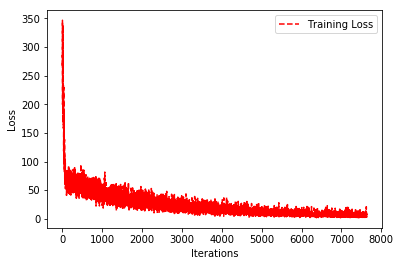

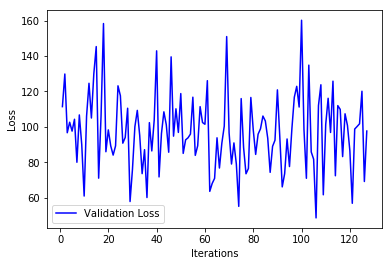

validation loss
97.2916427759


In [25]:
# Get training and validation loss histories

# Create count of the number of epochs
epoch_count = range(1, len(trn_losses) + 1)

# Visualize loss history
plt.plot(epoch_count, trn_losses, 'r--')

plt.legend(['Training Loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show();

epoch_count = range(1, len(val_losses) + 1)

# Visualize loss history
plt.plot(epoch_count, val_losses, 'b-')

plt.legend(['Validation Loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show();


print "validation loss"
print np.mean(val_losses)

In [26]:
# model save
# run validation accuracy
# train validation graph
# sparse optical flow
# images code made to run without commenting 
# last image regenerated to account for the pairs and last batch success


In [27]:
print "training loss"
print np.mean(trn_losses)

training loss
23.2692640597


In [28]:
#### TESTING STARTS ###############

net_val.eval()
def generate_test_data(data,batch_size):
    channels=3
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    batch_data = []
    batch_labels = []

    for j in range(len(data)//batch_size):
        for i in range(batch_size):
            if (i+j*batch_size)+1 == len(data):
                break
            row1=data.iloc[[i+j*batch_size]]
            row2=data.iloc[[(i+j*batch_size)+1]]
            
            img1 = preprocessing(row1['image_path'].values[0])
            img2 = preprocessing(row2['image_path'].values[0])

            speed1 = row1['speed'].values[0]
            speed2 = row2['speed'].values[0]

            resimg = computeOpticalFlow(img1,img2)
            resimg = resimg.reshape(1, resimg.shape[0], resimg.shape[1], resimg.shape[2])
            
            speed = np.mean([speed1, speed2])
            speed = np.array([[speed]])
            
            image_batch[i] = resimg
            label_batch[i] = speed
        
        img_batch=image_batch
        img_batch = np.reshape(img_batch, (batch_size, channels, 66, 220))
        
        batch_data.append(torch.from_numpy(img_batch))
        batch_labels.append(torch.DoubleTensor(label_batch))
        
    return zip(batch_data, batch_labels)

batch_size=32

testloader=list(generate_test_data(test_df,batch_size))
test_num = len(testloader)
print("Finish loading %d minibatches(=%d) of validation samples." % (test_num, batch_size))

Finish loading 269 minibatches(=32) of validation samples.


In [29]:
### Testing
test_start_time = time.time()


test_start_time = time.time()
test_losses = []
criterion = nn.MSELoss()

for i, datatest in enumerate(testloader, 0):
    inputs, labels = datatest
    
    outputs = net_val(inputs)
    labels=labels.view(-1,1)
    
    test_loss = criterion(outputs, labels)

    test_losses.append(test_loss.item())
          
         
print('Testing done')
test_end_time = time.time() - test_start_time
print('------------------------------------------------------------')
print("time taken to TEST for DenseOpticalFlow  in seconds {:.3f}".format(test_end_time))
print('Test MSE :::::: ')
print np.mean(test_losses)

Testing done
------------------------------------------------------------
time taken to TEST for DenseOpticalFlow  in seconds 79.182
Test MSE :::::: 
128.53721655


In [30]:
print np.mean(test_losses)

128.53721655
